## OFFICIAL NOTEBOOK : Diabetes in the US

Authors : Paul Sheng, Corisande Portalier, Gonzalo Arroyo, Pierre Krakovitch

In [9]:
#Packages / Modules
#Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Estimation
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

#Modules DAG
import networkx as nx
from pgmpy.base.DAG import DAG
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

#Exploration
from IPython.display import display

#Randomization tests
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

# INTRODUCTION



### Intro
The purpose of this project is to estimate the determinants of the readmission of diabetic patients to US hospitals in the 30 days after their first admission (or diagnosis). More precisely, we try to assess the effect of the HbA1c test (Glycated hemoglobin) on this readmission.

For this purpose, we have access to a dataset constructed by Strack et al. (2013) from the US Health Facts database (an important data warehouse containing medical records from across the country's hospitals). From the original 74M observations database spanning 130 hospitals over 10 years (1999-2008), the authors keep 101766 observations (only hospital patients diagnosed with diabetes at some point during the counter, that stayed for 1-14 days, and had laboratory tests performed) each with 55 attributes (from the original 117, selected by clinical experts for their relevance regarding the diabetic condition). These features include demographic variables (age, genre, weight, race), diagnoses, diabetic medications, medical record (number of visits in the year preceding the encounter) and payer information. Finally it contains the main outcome variable, which records whether the patient was readmitted to an hospital under 30 days, over 30 days or not at all.

The initial research question asked by the authors of the paper was : “What is the effect of HbA1c measurement on hospital readmission rates at 30 days?” The intrinsic motivation behind it was to optimize medical processes and allow for cost savings ; if the test does hold predictive power, one should generalize its use.

Our approach is thus to replicate the paper to make sure we handle the dataset correctly, refine its analysis and engage in a new predictive exercise
More precisely, we engage on one hand, in an "explainable" predictive exercise - can we predict readmission using other covariates availaible? 
And on the other hand, a refinement of the paper's approach : is it possible to better identify the predictive power of the test on readmission?

The paper has established a significant and negative effect of Tested * High on readmission using a logistic model while controlling for a limited number of variables.
What if we change the model specification? Will it change the direction/magnitude of the effect? By controlling for more covariates, will the significance remain?
If it is possible to predict readmission using other covariates than the test, can we "get rid of" the test? Would that bring more clarity to the "channel" through which the HBA1C test holds predictive power?


Therefore our analysis is structured in the following way :
### Plan
##### I) Exploratory Analysis and Randomization analysis : to preliminarily determine the links between covariates and whether the treatment is random or determined by covariates, leading to a "causality" analysis in the form of DAGs
##### II) A "explainable" predictive exercise using Random Forest and Gradient Boosting methods to predict the readmission, without particularly isolating the effects of the test
##### III) Replication of the paper's logit model and refining its analysis using other model specifications i.e. Double Post-Lasso and Duration models


#### Note : the part of the code focusing on the replication and refinement of the paper is contained in a separate STATA file.

# I. Exploratory Analysis and Randomization Analysis



## I. A. Data cleaning and recoding

In [89]:
# Initial Dataset
diabetic_data = pd.read_csv("C:\\Users\\boyan\\Documents\\MiE2\\Machine Learning for Econometrics\\Projet\\diabetes+130-us+hospitals+for+years+1999-2008(1)\\diabetic_data.csv")
IDS_mapping = pd.read_csv("C:\\Users\\boyan\\Documents\\MiE2\\Machine Learning for Econometrics\\Projet\\diabetes+130-us+hospitals+for+years+1999-2008(1)\\IDS_mapping.csv")

##### Following *Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records* by B. Strack et al. (2014), we filter out some observations from the dataset :
- ##### To avoid any correlation between variables, we only keep the first encounter for each individual
- ##### We remove encouters that resulted in discharge to a hospice or death (and neoborn)

##### As a preliminary remark, some variables have a lot of missing values and are therefore not usable for our analysis.

In [90]:
#DATA MANAGEMENT
diabetic_data["discharge_disposition_id"] = pd.to_numeric(diabetic_data["discharge_disposition_id"], errors="coerce")

# Admission types to remove
exclude_ids = [10,11, 13, 14, 19, 20, 21, 26]

#remove nan if any
diabetic_data["discharge_disposition_id"] = pd.to_numeric(diabetic_data["discharge_disposition_id"], errors="coerce")

# Keep only rows where 'admission_type_id' is not the exclude_ids
data_cleaned = diabetic_data[~diabetic_data["discharge_disposition_id"].isin(exclude_ids)]

# Remove duplicate patient
data_cleaned = data_cleaned.drop_duplicates(subset="patient_nbr", keep="first")

##### Then, still following the paper, we recoded some variables :

In [91]:
#Classer to recode the primary diagnostic variable
def classer_icd9(code):
    try:
        code_num = float(code)
    except ValueError:
        return "Other"

    if (390 <= code_num <= 459) or code_num == 785:
        return "Circulatory"
    elif (460 <= code_num <= 519) or code_num == 786:
        return "Respiratory"
    elif (520 <= code_num <= 579) or code_num == 787:
        return "Digestive"
    elif 250 <= code_num < 251:
        return "Diabetes"
    elif 800 <= code_num <= 999:
        return "Injury"
    elif 710 <= code_num <= 739:
        return "Musculoskeletal"
    elif (580 <= code_num <= 629) or code_num == 788:
        return "Genitourinary"
    elif (140 <= code_num <= 239) or code_num in {780, 781, 784} or 790 <= code_num <= 799:
        return "Neoplasms"
    else:
        return "Other"

#To recode the HbA1c variable
def HbA1c_code2(row):
    code = row["A1Cresult"]
    change = row["change"]
    if code in ["Norm", ">7"]:
        return "Normal"
    elif code == ">8" and change == "Ch":
        return "High_c"
    elif code == ">8" and change == "No":
        return "High_nc"
    elif code == "None":
        return "None"
    return None

# === Diagnosis ===
data_cleaned["diag_1"] = pd.to_numeric(data_cleaned["diag_1"], errors='coerce')
data_cleaned["diag_2"] = pd.to_numeric(data_cleaned["diag_2"], errors='coerce')
data_cleaned["diag_3"] = pd.to_numeric(data_cleaned["diag_3"], errors='coerce')

data_cleaned["prim_diag"] = data_cleaned["diag_1"].apply(classer_icd9)
data_cleaned["sec_diag"] = data_cleaned["diag_2"].apply(classer_icd9)
data_cleaned["third_diag"] = data_cleaned["diag_3"].apply(classer_icd9)

# === HbA1c ===
data_cleaned["HbA1c"] = data_cleaned.apply(HbA1c_code2, axis=1)

# ==== Discharge disposition ===
data_cleaned["discharge"] = data_cleaned["discharge_disposition_id"].apply(lambda x: "Home" if x == 1 else "Other")


# ==== READMITTED ===
readmitted_mapping = {'NO': 0, '<30': 1, '>30': 0}  # On considère <30 comme la réadmission
data_cleaned['readmitted_binary'] = data_cleaned["readmitted"].map(readmitted_mapping)

##### In the original dataset, the primary diagnosis (made during the admission at the hospital) is represented by a code. We recode the variable into a categorical variable that shows the explicit name of the diagnosis using a simple classifier.

##### Like in the paper, we turn the discharge disposition variable to a binary variable telling whether the patient was discharged at home or elsewhere, making it easier to use for analysis, and eliminating very small categories within the original variable.

##### Considering, like in the paper, that only a readmission under 30 days in interesting in terms of measuring effects from the hospital encounter, we recode the readmission variable to be binary, which also makes later analysis and classification easier.

In [92]:
# === MEDICAL SPECIALTY ===
mapping = {
    'Cardiology': 'Cardiology',
    'Family/GeneralPractice': 'General practice',
    'InternalMedicine': 'Internal medicine',
    '?': 'Missing',
    'PhysicianNotFound': 'Missing',
    'SurgicalSpecialty': 'Surgery',
    'Surgery-General': 'Surgery',
    'Surgery-Cardiovascular/Thoracic': 'Surgery',
    'Surgery-Neuro': 'Surgery',
    'Surgery-Colon&Rectal': 'Surgery',
    'Surgery-Thoracic': 'Surgery',
    'Surgery-Plastic': 'Surgery',
    'Surgery-Pediatric': 'Surgery',
    'Surgery-Vascular': 'Surgery',
    'Surgery-Maxillofacial': 'Surgery',
    'Surgeon': 'Surgery'
}

data_cleaned['medical_specialty'] = data_cleaned['medical_specialty'].map(lambda x: mapping[x] if x in mapping else 'Other')

# === ADMISSION SOURCE  ===
admission_mapping = {
    1: 'Referral',
    2: 'Referral',
    3: 'Referral',
    7: 'Emergency',
}

data_cleaned['admission'] = data_cleaned['admission_source_id'].map(admission_mapping).fillna('Other')

# ==== RACE ====
race_mapping = {
    'AfricanAmerican': 'African American',
    'Caucasian': 'Caucasian',
    '?': 'Missing'
}

data_cleaned['race'] = data_cleaned['race'].map(lambda x: race_mapping[x] if x in race_mapping else 'Other')



df_alt = data_cleaned.copy()

# === AGE GROUP ===
data_cleaned['age_group'] = pd.cut(
    data_cleaned['age'].str.extract(r'(\d+)')[0].astype(float),
    bins=[0, 30, 60, 100],
    labels=["<30", "30-60", "60+"]
)

# === HbA1c CATEGORY ===
data_cleaned['HbA1c_tested'] = data_cleaned['HbA1c'].notna().astype(int)

data_cleaned["early_readmission"] = diabetic_data["readmitted"].apply(lambda x: "readmitted" if x == "<30" else "otherwise")
readmitted_data = data_cleaned[data_cleaned["readmitted"] == "<30"]

data_cleaned['HbA1c'] = data_cleaned['HbA1c'].fillna('No_measure')
data_cleaned['HbA1c'] = pd.Categorical(data_cleaned['HbA1c'], categories=['No_measure', 'Normal', 'High_c', 'High_nc'])


df = data_cleaned.copy()

##### Much like before, we follow the cited paper, mostly gathering smaller categories into bigger ones or into "Others", for the specialty of the admitting doctor, race of the patient and admission source.

##### Using this cleaned and recoded dataset, we then run exploratory analysis on the main variables.

## I. B. Exploration

### I. B. a. Statistical description

##### Let's first explore some of the main features available : HbA1c test results, the primary diagnosis, admission source, age,

##### First, here is a summary statistics :

In [14]:
#? processing
df[["weight","payer_code"]] = df[["weight","payer_code"]].replace('?', np.nan)

# Variables numériques
num_vars = df.select_dtypes(include=['int64', 'float64']).columns
num_summary = df[num_vars].describe().T
num_summary['missing_pct'] = df[num_vars].isna().mean() * 100
num_summary = num_summary.round(2)

# Variables catégorielles
cat_vars = df.select_dtypes(include='object').columns
cat_summary = []

for col in cat_vars:
    counts = df[col].value_counts(dropna=False)
    top = counts.index[0]
    freq = counts.iloc[0]
    unique = df[col].nunique(dropna=True)
    missing = df[col].isna().mean() * 100
    cat_summary.append({
        'variable': col,
        'unique_values': unique,
        'top_value': top,
        'top_count': freq,
        'missing_pct': round(missing, 2)
    })

cat_summary_df = pd.DataFrame(cat_summary).set_index('variable')

# Affichage côte à côte

print("📊 Variables numériques")
display(num_summary)

print("\n📋 Variables catégorielles")
display(cat_summary_df)

##Faut que je fasse un changement pour que '?' soit traité comme une missing value

📊 Variables numériques


,count,mean,std,min,25%,50%,75%,max,missing_pct
encounter_id,69984.0,1.566858e+08,1.003849e+08,12522.0,81321076.5,143872380.0,215384374.5,443867222.0,0.00
patient_nbr,69984.0,5.494647e+07,3.948937e+07,135.0,23342098.5,47982874.5,87500907.0,189502619.0,0.00
admission_type_id,69984.0,2.110000e+00,1.510000e+00,1.0,1.0,1.0,3.0,8.0,0.00
discharge_disposition_id,69984.0,3.410000e+00,5.180000e+00,1.0,1.0,1.0,3.0,28.0,0.00
admission_source_id,69984.0,5.640000e+00,4.170000e+00,1.0,1.0,7.0,7.0,25.0,0.00
time_in_hospital,69984.0,4.270000e+00,2.930000e+00,1.0,2.0,3.0,6.0,14.0,0.00
num_lab_procedures,69984.0,4.287000e+01,1.989000e+01,1.0,31.0,44.0,57.0,132.0,0.00
num_procedures,69984.0,1.430000e+00,1.760000e+00,0.0,0.0,1.0,2.0,6.0,0.00
num_medications,69984.0,1.567000e+01,8.290000e+00,1.0,10.0,14.0,20.0,81.0,0.00
number_outpatient,69984.0,2.800000e-01,1.060000e+00,0.0,0.0,0.0,0.0,42.0,0.00



📋 Variables catégorielles


,unique_values,top_value,top_count,missing_pct
variable,,,,
race,4,Caucasian,52300,0.00
gender,3,Female,37235,0.00
age,10,[70-80),17749,0.00
weight,9,NaN,67196,96.02
payer_code,17,NaN,30410,43.45
medical_specialty,6,Missing,33657,0.00
max_glu_serum,3,NaN,66640,95.22
A1Cresult,3,NaN,57139,81.65
metformin,4,No,55079,0.00


#### Readmitted
Let's explore the readmission variable, in relation with other variables such as the HbA1c test result, the age group

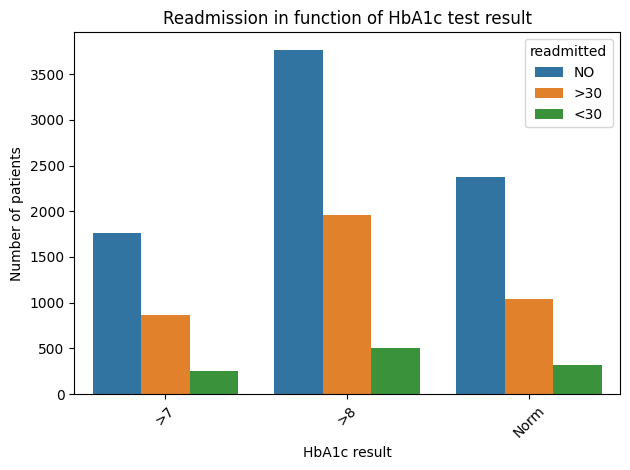

In [15]:
sns.countplot(data=df, x='A1Cresult', hue='readmitted')
plt.title('Readmission in function of HbA1c test result')
plt.xlabel('HbA1c result')
plt.ylabel('Number of patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

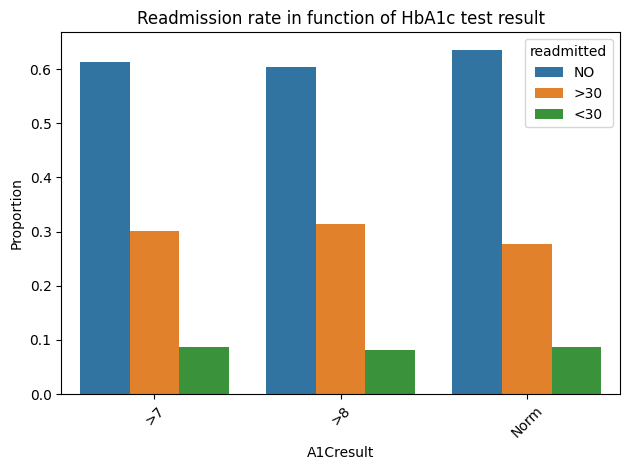

In [16]:
#Normalized version
readmit_rates = (
    df.groupby('A1Cresult')['readmitted']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

sns.barplot(data=readmit_rates, x='A1Cresult', y='proportion', hue='readmitted')
plt.title('Readmission rate in function of HbA1c test result')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Readmission according to the age group

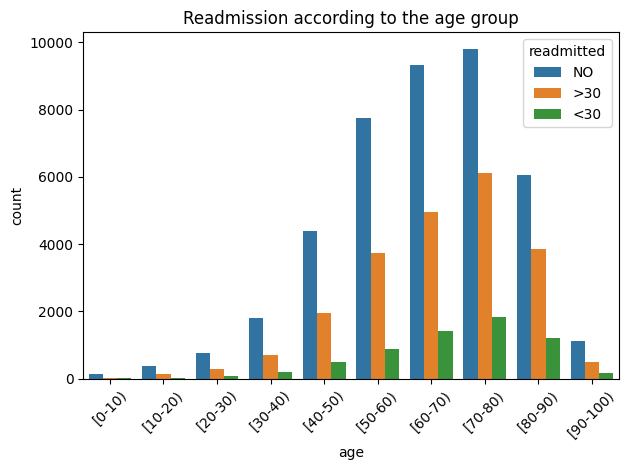

In [17]:
sns.countplot(data=df, x='age', hue='readmitted')
plt.title('Readmission according to the age group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

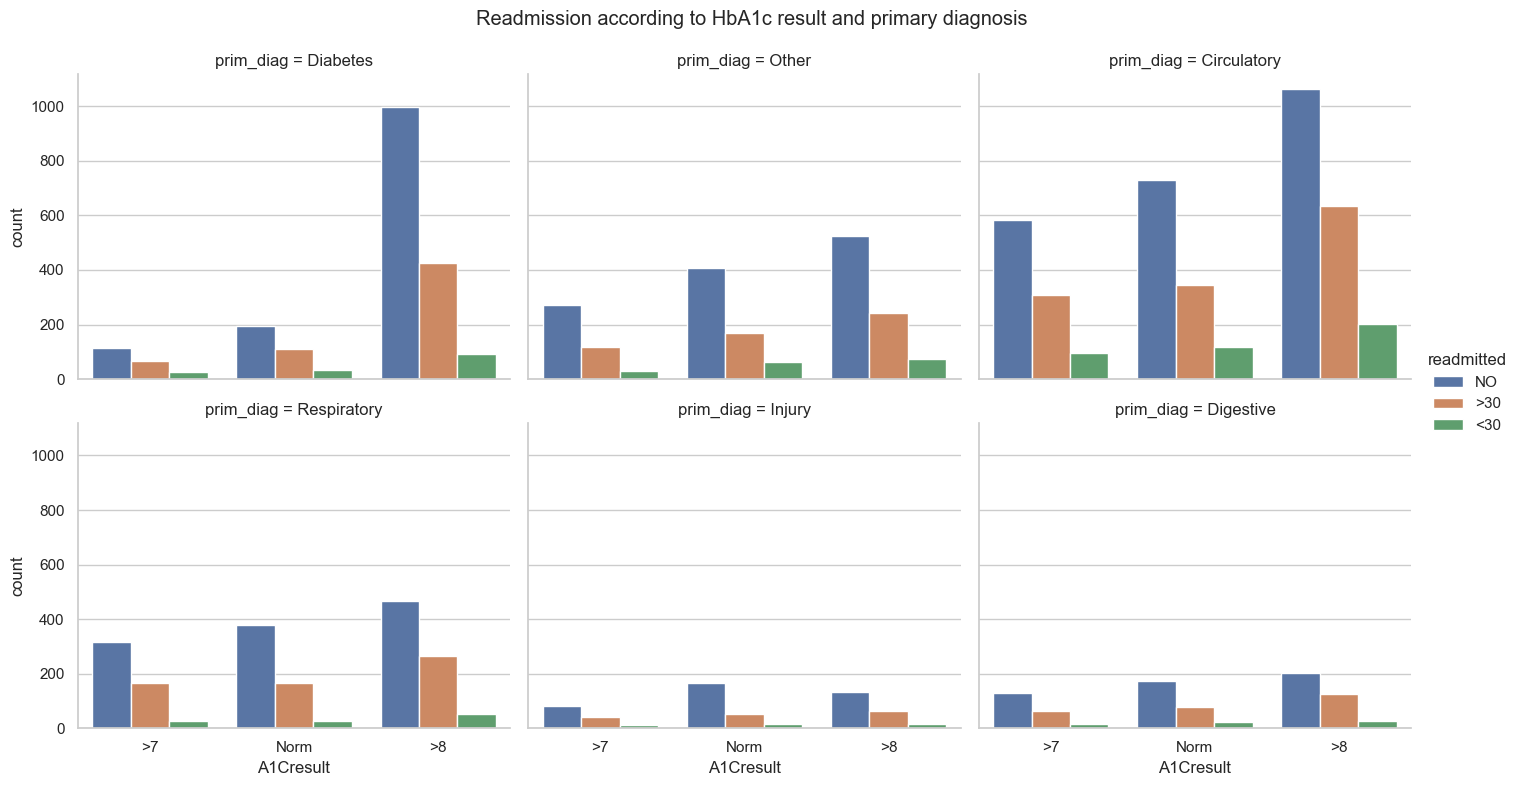

In [18]:
# Prendre les diagnostics les plus fréquents pour ne pas surcharger la figure
top_diagnoses = df['prim_diag'].value_counts().nlargest(6).index
df_diag = df[df['prim_diag'].isin(top_diagnoses)]

sns.set(style='whitegrid')
g = sns.catplot(
    data=df_diag,
    x='A1Cresult', hue='readmitted', col='prim_diag',
    kind='count', col_wrap=3, height=4, aspect=1.2
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Readmission according to HbA1c result and primary diagnosis")
plt.show()

### Primary Diagnosis

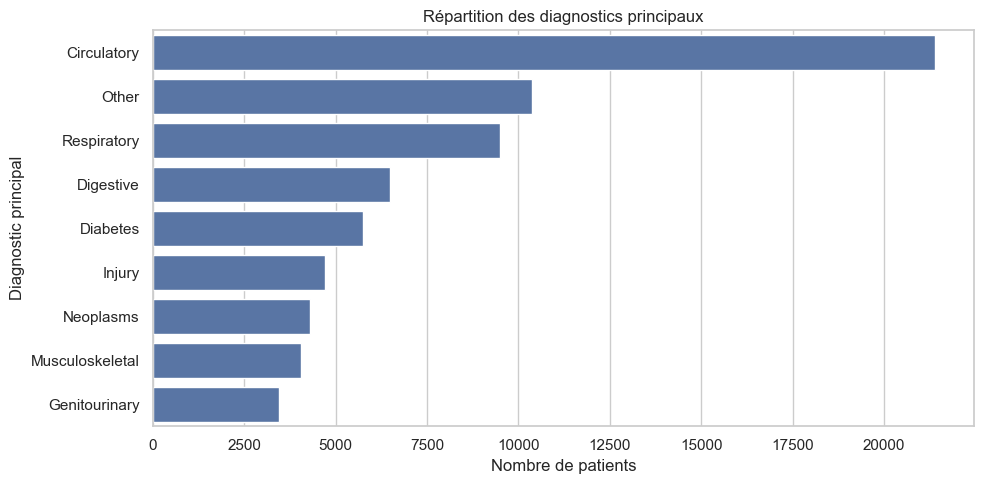

In [19]:
#Viz générale prim diag
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='prim_diag', order=df['prim_diag'].value_counts().index)
plt.title('Répartition des diagnostics principaux')
plt.xlabel('Nombre de patients')
plt.ylabel('Diagnostic principal')
plt.tight_layout()
plt.show()


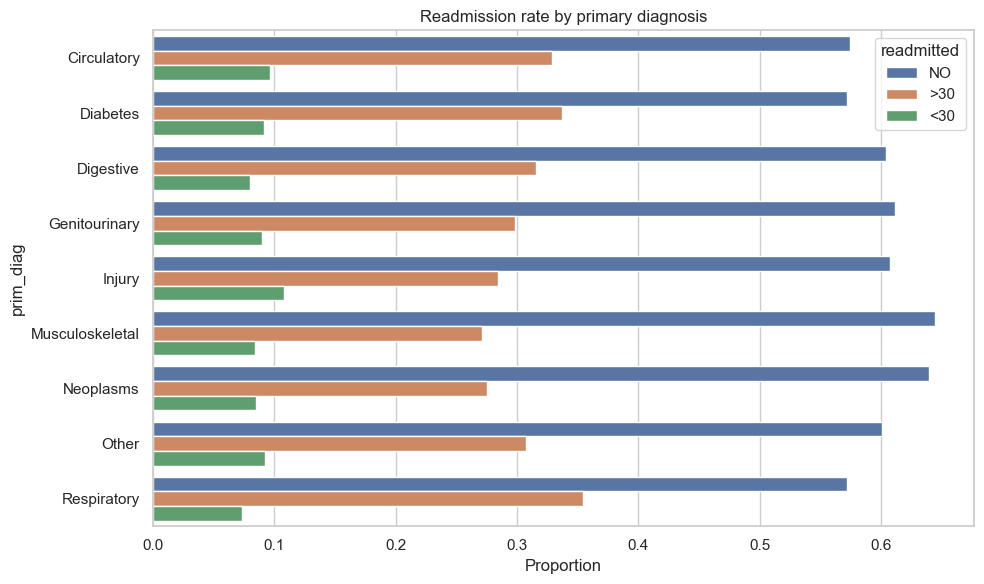

In [20]:
#Readmission by primary diagnostic (w/o HbA1c) (Simpler version of the previous visualization)
diag_readmit = (
    df.groupby('prim_diag')['readmitted']
    .value_counts(normalize=True)
    .rename('Proportion')
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=diag_readmit, y='prim_diag', x='Proportion', hue='readmitted')
plt.title('Readmission rate by primary diagnosis')
plt.tight_layout()
plt.show()

### Medical Specialty of admission

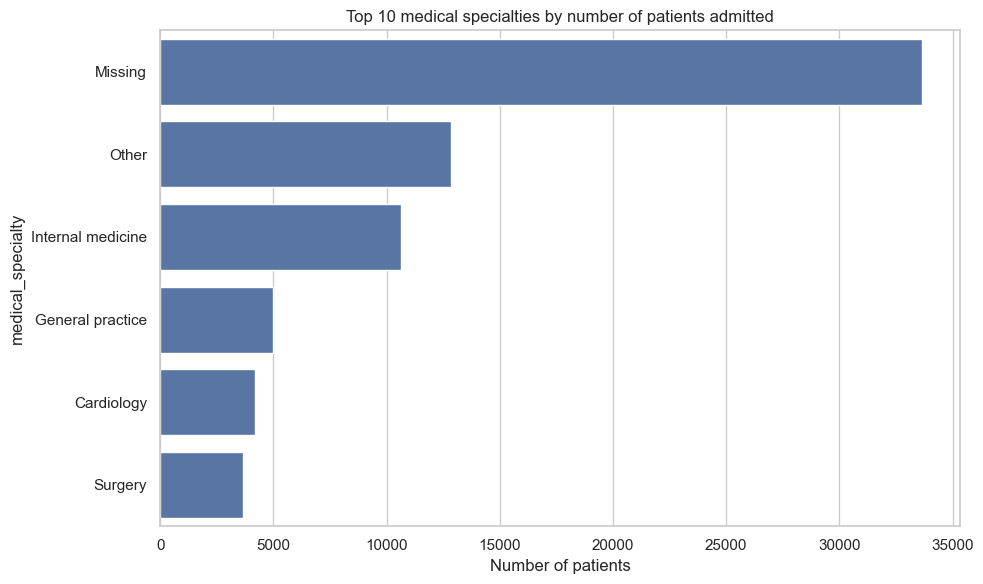

In [21]:
##MEDICAL SPECIALTY
top_specs = df['medical_specialty'].value_counts().nlargest(10).index
df_spec = df[df['medical_specialty'].isin(top_specs)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_spec, y='medical_specialty', order=top_specs)
plt.title('Top 10 medical specialties by number of patients admitted')
plt.xlabel('Number of patients')
plt.tight_layout()
plt.show()

##### Mostly shows that a lot of the data is missing.

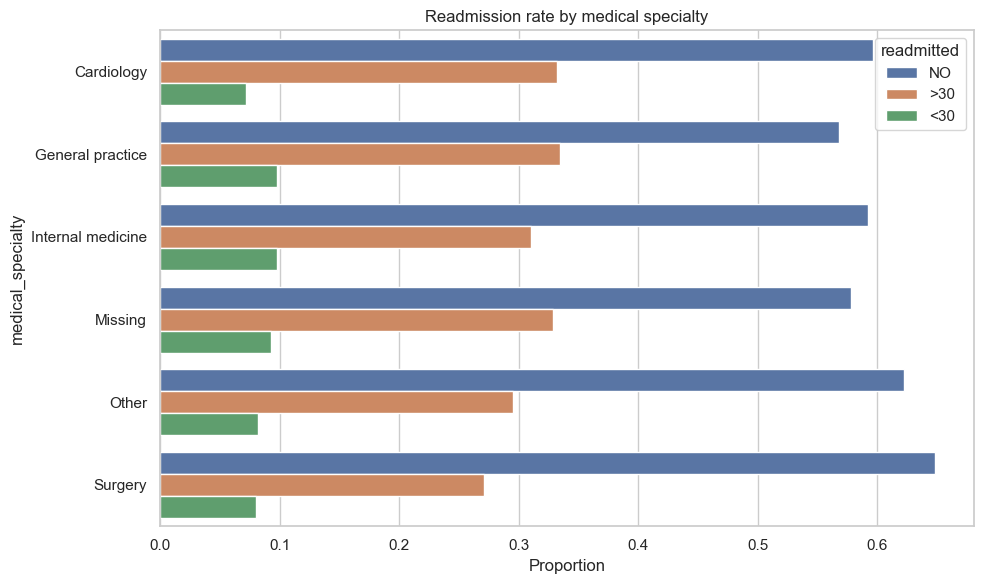

In [22]:
spec_readmit = (
    df_spec.groupby('medical_specialty')['readmitted']
    .value_counts(normalize=True)
    .rename('Proportion')
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=spec_readmit, y='medical_specialty', x='Proportion', hue='readmitted')
plt.title('Readmission rate by medical specialty')
plt.tight_layout()
plt.show()


### Admission source
##### The readmission rate is rather balanced between sources.

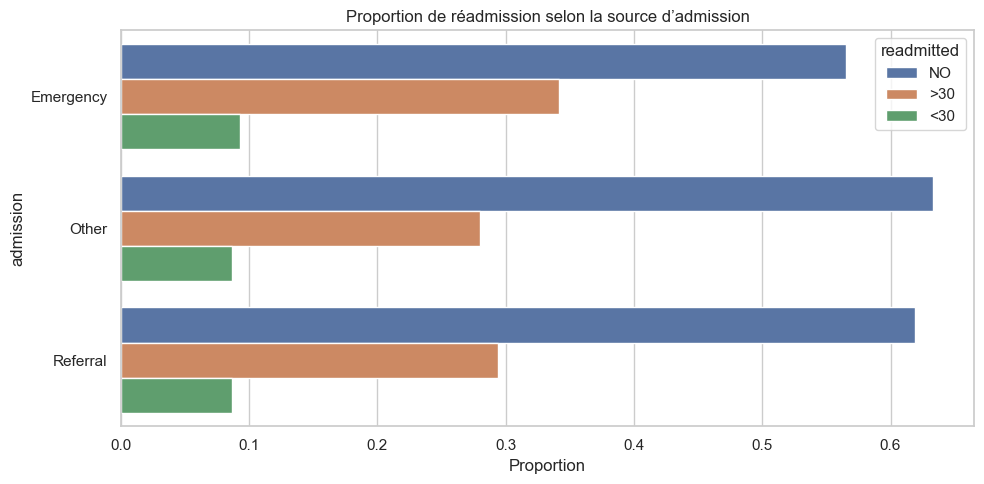

In [23]:
adm_readmit = (
    df.groupby('admission')['readmitted']
    .value_counts(normalize=True)
    .rename('Proportion')
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=adm_readmit, y='admission', x='Proportion', hue='readmitted')
plt.title('Proportion de réadmission selon la source d’admission')
plt.tight_layout()
plt.show()

### Medication change

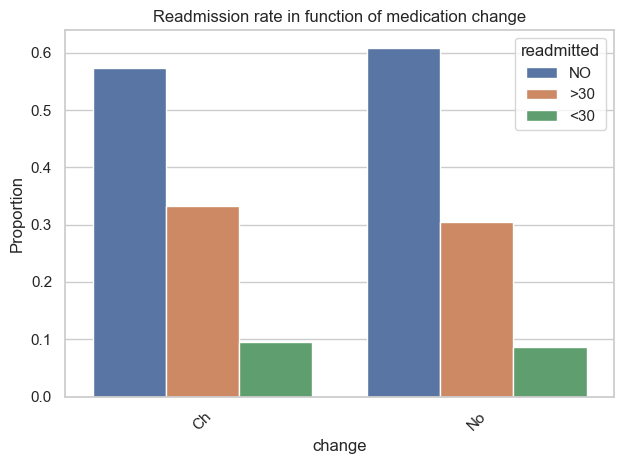

In [24]:
#Normalized version
readmit_rates = (
    df.groupby('change')['readmitted']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

sns.barplot(data=readmit_rates, x='change', y='proportion', hue='readmitted')
plt.title('Readmission rate in function of medication change')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### No obvious heterogeneity in readmission rate according to a change in medication during the encounter.

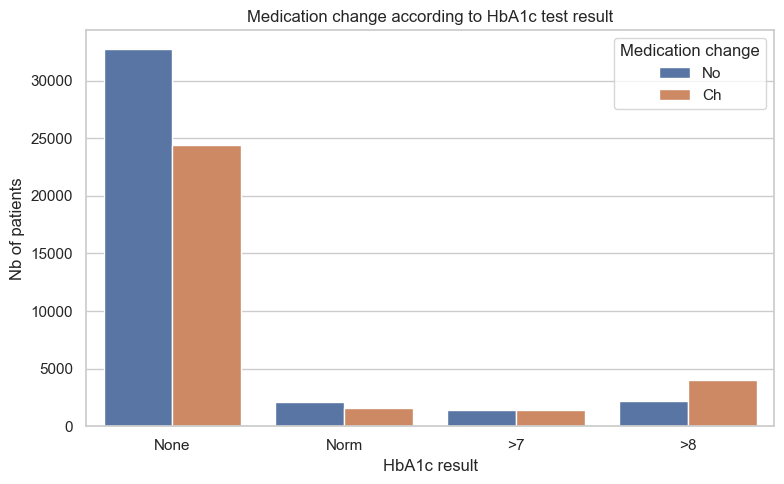

In [25]:
#Supplementary analysis on the relationship between A1Cresult and HbA1c

df['A1Cresult_2'] = df['A1Cresult'].fillna('None')

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='A1Cresult_2', hue='change', order=['None', 'Norm', '>7', '>8'])
plt.title("Medication change according to HbA1c test result")
plt.xlabel("HbA1c result")
plt.ylabel("Nb of patients")
plt.legend(title="Medication change")
plt.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


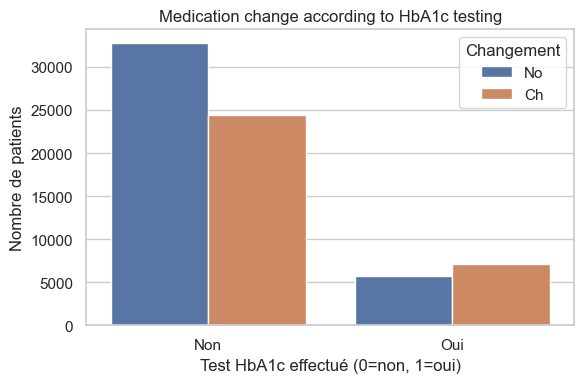

In [26]:
#For HbA1C BINARY
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HbA1c_tested', hue='change')
plt.title("Medication change according to HbA1c testing")
plt.xlabel("Test HbA1c effectué (0=non, 1=oui)")
plt.ylabel("Nombre de patients")
plt.xticks([0, 1], ['Non', 'Oui'])
plt.legend(title="Changement")
plt.tight_layout()
plt.show()

##### Overall, this exploratory analysis does not heavily suggest any causality link between the main covariates used in the dataset. Interesting information could have probably been extracted from the weight variable, unfortunately it is mostly missing and therefore unusable.

### I. B. b Randomization analysis

##### Following this preliminary visual analysis of the main variable, we try to more closely analyze the structure of the treatment (considered here as having been tested for HbA1c or not).
##### Nothing in the production of the dataset suggests that the treatment (the HbA1c test) was performed randomly. We still try to assess how random it is, or how correlated it is with the available observables.
##### To do this, we first try to visualize the two groups (treated and non-treated) using a simple Principal Component Analysis

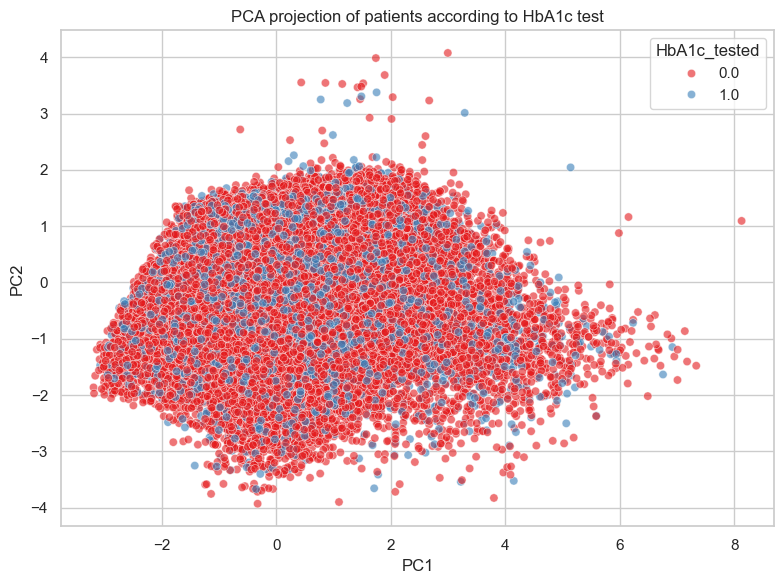

In [27]:
covariates = ['age', 'gender', 'race', 'time_in_hospital', 'num_medications',
              'num_procedures', 'number_diagnoses', 'prim_diag', 'medical_specialty', 'admission']

num_vars = ['time_in_hospital', 'num_medications', 'num_procedures', 'number_diagnoses']
cat_vars = ['age', 'gender', 'race', 'prim_diag', 'medical_specialty', 'admission']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars)
])

pca_pipeline = make_pipeline(preprocessor, PCA(n_components=2))
X_pca = pca_pipeline.fit_transform(df[covariates])

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['HbA1c_tested'] = df['HbA1c_tested']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='HbA1c_tested', palette='Set1', alpha=0.6)
plt.title("PCA projection of patients according to HbA1c test")
plt.tight_layout()
plt.show()

##### The treatment does not seem very structured by the observed covariates.

##### To get a better/more quantitative analysis, we run Khi**2 tests of independence between the treated and non-treated populations :

In [28]:
def chi2_test(col):
    table = pd.crosstab(df[col], df['HbA1c_tested'])
    chi2, p, dof, expected = chi2_contingency(table)
    return pd.Series({'p-value': p, 'chi2': chi2})

# Variables qualitatives à tester :
categorical_vars = ['readmitted', 'race', 'gender', 'age', 'prim_diag', 'medical_specialty', 'admission']

chi2_results = pd.DataFrame({var: chi2_test(var) for var in categorical_vars}).T
chi2_results.sort_values('p-value')


,p-value,chi2
prim_diag,0.000000e+00,1708.277216
age,3.785556e-257,1220.869561
admission,3.230481e-189,868.031903
medical_specialty,3.833537e-72,343.773245
race,2.884231e-29,135.906359
gender,3.768542e-09,38.793155
readmitted,3.946961e-08,34.095470


In [29]:
numerical_vars = ['time_in_hospital', 'num_medications', 'num_procedures', 'number_diagnoses']
ttest_results = {}

for var in numerical_vars:
    group1 = df[df['HbA1c_tested'] == 1][var].dropna()
    group0 = df[df['HbA1c_tested'] == 0][var].dropna()
    stat, p = ttest_ind(group1, group0, equal_var=False)
    ttest_results[var] = {'p-value': p, 'mean_tested': group1.mean(), 'mean_not_tested': group0.mean()}

pd.DataFrame(ttest_results).T

,p-value,mean_tested,mean_not_tested
time_in_hospital,5.097675e-79,4.731179,4.170164
num_medications,2.217109e-06,15.989801,15.592678
num_procedures,3.386377e-13,1.320903,1.448958
number_diagnoses,3.114073e-02,7.188712,7.232381


#### The results suggest that the treatment is not random as we can reject the independence hypothesis with very high confidence. We can therefore say that there is a bias in the distribution/in how the treatment was performed. Let's now assess how big this difference is using Logistic Regression.

In [30]:
features = ['age', 'race', 'gender', 'prim_diag', 'medical_specialty', 'admission']
X = df[features]
y = df['HbA1c_tested']

# Encodage catégoriel
preproc = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), features)
])

model = make_pipeline(preproc, LogisticRegression(max_iter=1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_prob)

np.float64(0.6425781846551063)

#### The ROC score is 0.64, which is right under the 0.7 threshold from which we can usually consider that the treatment is not random. We may then consider that the treatment is not completely random, but not strongly determined by observables.
#### We complement this analysis using a Standard Mean-Difference to assess the balance in covariates between the treated and non-treated.

In [31]:
# SMD functio,
def compute_smd(x1, x0):
    mean_diff = np.mean(x1) - np.mean(x0)
    pooled_std = np.sqrt((np.var(x1, ddof=1) + np.var(x0, ddof=1)) / 2)
    return mean_diff / pooled_std

# Group separation
treated = df[df['HbA1c_tested'] == 1]
control = df[df['HbA1c_tested'] == 0]

# Numerical variables to compare
num_vars = ['time_in_hospital', 'num_medications', 'num_procedures', 'number_diagnoses']

smd_num = {}
for var in num_vars:
    smd = compute_smd(treated[var].dropna(), control[var].dropna())
    smd_num[var] = smd

# Categorical variables
cat_vars = ['age', 'race', 'gender', 'prim_diag', 'medical_specialty', 'admission', 'change']
encoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(df[cat_vars])
columns = encoder.get_feature_names_out(cat_vars)

df_encoded = pd.DataFrame(X_cat, columns=columns)
df_encoded['HbA1c_tested'] = df['HbA1c_tested'].values

smd_cat = {}
for col in columns:
    smd = compute_smd(df_encoded[df_encoded['HbA1c_tested'] == 1][col],
                      df_encoded[df_encoded['HbA1c_tested'] == 0][col])
    smd_cat[col] = smd

# Result summary
smd_all = {**smd_num, **smd_cat}
smd_df = pd.DataFrame.from_dict(smd_all, orient='index', columns=['SMD'])
smd_df['|SMD|'] = smd_df['SMD'].abs()
smd_df = smd_df.sort_values(by='|SMD|', ascending=False)

smd_df.head(20)

#Interpretation :
# - SMD < 0.1 → différence négligeable (bon équilibre)
# - SMD 0.1–0.25 → différence modérée
# - SMD > 0.25 → déséquilibre important

,SMD,|SMD|
prim_diag_Diabetes,0.307141,0.307141
admission_Emergency,0.293753,0.293753
change_No,-0.249928,0.249928
admission_Referral,-0.220644,0.220644
time_in_hospital,0.188107,0.188107
prim_diag_Musculoskeletal,-0.154689,0.154689
medical_specialty_Internal medicine,0.142897,0.142897
age_[10-20),0.142725,0.142725
age_[40-50),0.136478,0.136478
age_[70-80),-0.133670,0.133670


##### Let's visualize the results :

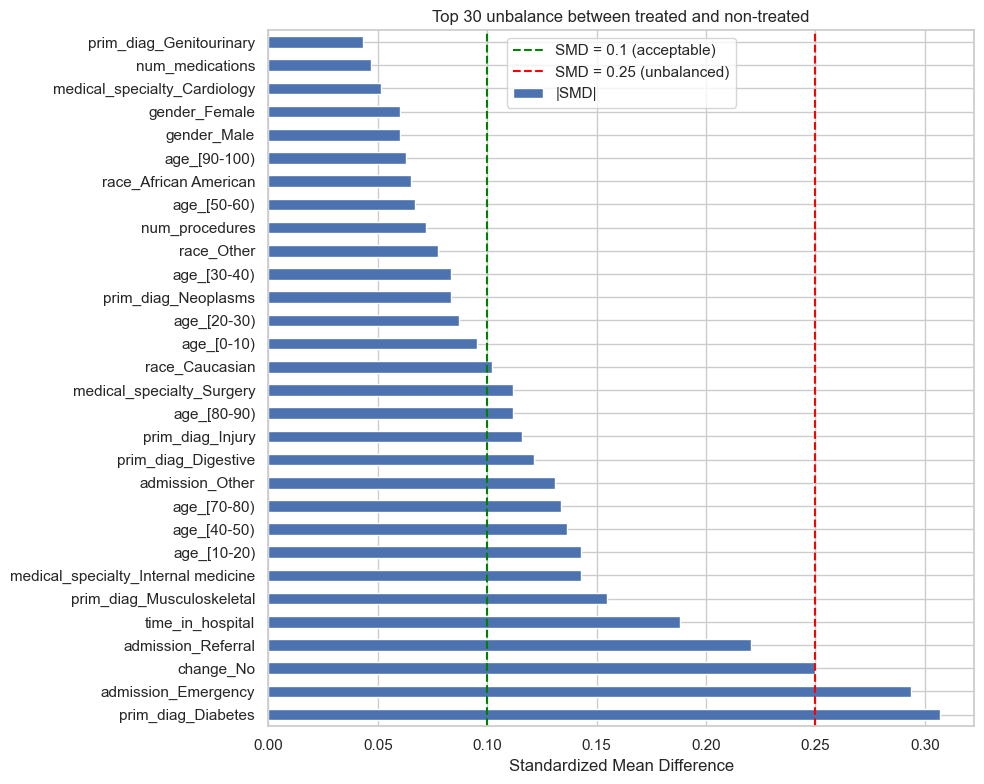

In [32]:
plt.figure(figsize=(10, 8))
smd_df['|SMD|'].head(30).plot(kind='barh')
plt.axvline(0.1, color='green', linestyle='--', label='SMD = 0.1 (acceptable)')
plt.axvline(0.25, color='red', linestyle='--', label='SMD = 0.25 (unbalanced)')
plt.xlabel("Standardized Mean Difference")
plt.title("Top 30 unbalance between treated and non-treated")
plt.legend()
plt.tight_layout()
plt.show()

##### Finally, we can conclude that, as suspected, the treatment is not random. However, it does not seem heavily determined by the available covariates. Perhaps mostly missing ones like the weight are important in its implementation, but cannot be used here unfortunately.

## I. C Preliminary Causality Analysis


##### Let's draw directed acyclic graphs of what we believe to be the causality chain at play here following these preliminary analysis.

A first hypothesis on how Test Results can "Granger cause" Readmission: 

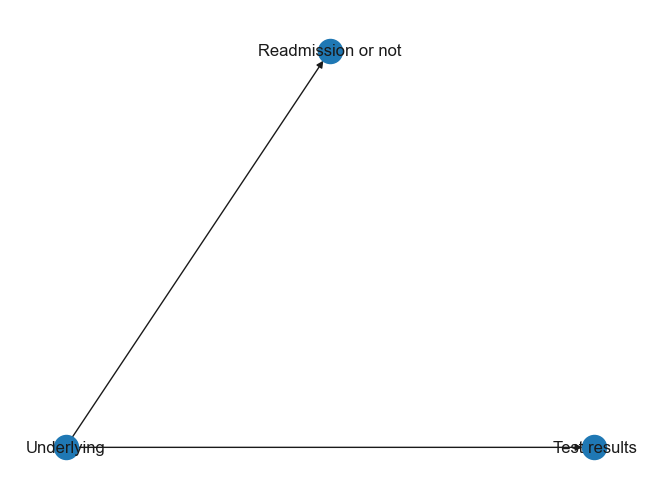

In [61]:
digraph2 = nx.DiGraph(
    [
        ("Underlying", "Test results"),
        ("Underlying", "Readmission or not"),
    ]
)
G = DAG(digraph2)
nx.draw_planar(G, with_labels=True)
plt.show()

A second hypothesis on how Test Results can "Granger cause" Readmission

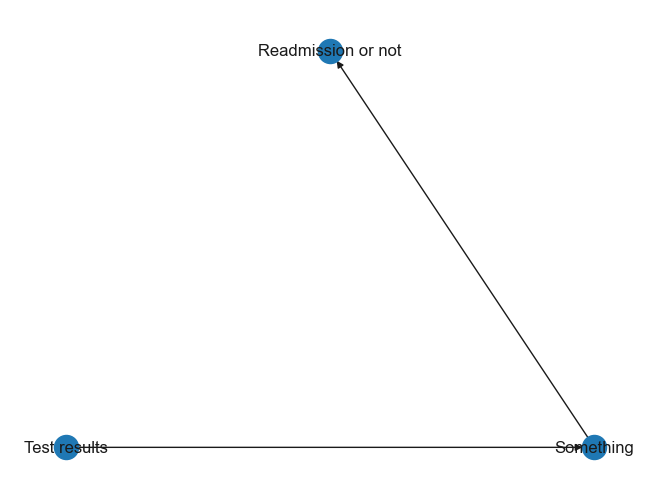

In [62]:
digraph3 = nx.DiGraph(
    [
        ("Test results", "Something"),
        ("Something", "Readmission or not"),
    ]
)
G = DAG(digraph3)
nx.draw_planar(G, with_labels=True)
plt.show()

Given the data, a plausible channel of transmission

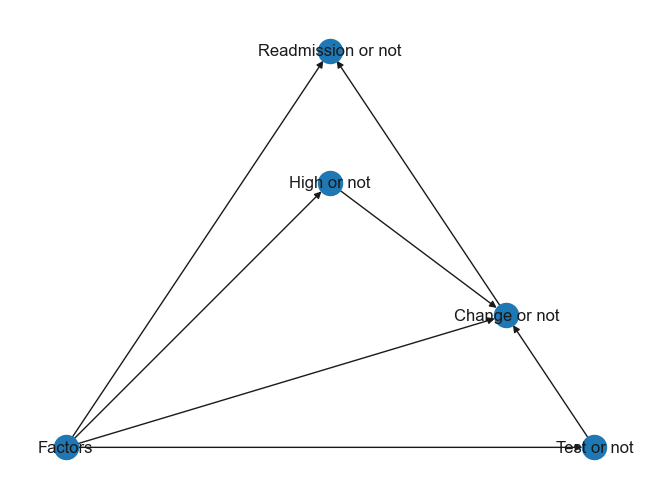

In [63]:
digraph3 = nx.DiGraph(
    [
        ("Factors", "Test or not"),
        ("Factors", "High or not"),
        ("Factors", "Change or not"),
        ("Factors", "Readmission or not"),
        ("Test or not", "Change or not"),
        ("High or not", "Change or not"),
        ("Change or not", "Readmission or not"),
    ]
)
G = DAG(digraph3)
nx.draw_planar(G, with_labels=True)
plt.show()

### I. D. Propensity Score Matching

##### First, we try to estimate the total effect the treatment understood as having been tested or not for HbA1c (regardless of the result). . To make this rather naive estimation, we use propensity score matching between the treated group (people who were tested) and control (not tested) on the main identified observables, that are the age group, gender, race, time spent at the hospital, discharge disposition and primary diagnosis.

##### For this purpose, we compute the propensity score of each treated and control individual, using what is essentially a logit of a new binary variable representing the treatment, on the main covariates. Then we match treated to the nearest control in terms of propensity score using nearest neighbors.

In [36]:
# Sélection des covariables pertinentes
covariates = ['age', 'gender', 'race', 'time_in_hospital', 'discharge', 'prim_diag']
df_encoded = pd.get_dummies(df[covariates], drop_first=True)

# Ajustement du modèle de Propensity Score
X = df_encoded
y = df['HbA1c_tested']
logit = LogisticRegression(max_iter=1000)
logit.fit(X, y)
df['propensity_score'] = logit.predict_proba(X)[:, 1]

# Séparation des groupes
treated = df[df['HbA1c_tested'] == 1]
control = df[df['HbA1c_tested'] == 0]

# Matching avec Nearest Neighbors
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

# Création du dataset apparié
matched_df = pd.concat([treated, matched_control])

# Vérification de la taille des groupes
matched_df['HbA1c_tested'].value_counts()

HbA1c_tested
1    12845
0    12845
Name: count, dtype: int64

#### We then plot the propensity score distributions of the treated and matched controls, to check that they are correctly matched.

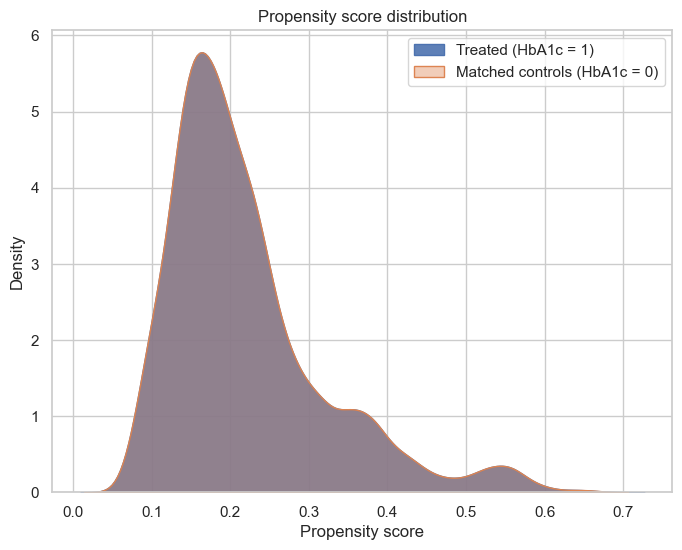

In [37]:
plt.figure(figsize=(8, 6))
sns.kdeplot(treated['propensity_score'], label="Treated (HbA1c = 1)", fill=True, alpha=0.9)
sns.kdeplot(matched_control['propensity_score'], label="Matched controls (HbA1c = 0)", fill=True, alpha=0.4)
plt.title("Propensity score distribution")
plt.xlabel("Propensity score")
plt.legend()
plt.show()

##### Finally we compute the treatment effect by comparing the readmission rate (under 30 days) for the treated and their matched controls.

In [38]:
# Comparaison des taux de réadmission entre le groupe traité et le groupe contrôle apparié
treated_outcome = treated['readmitted_binary']
control_outcome = matched_control['readmitted_binary']

# Test t de Student pour comparer les moyennes
t_stat, p_value = ttest_ind(treated_outcome, control_outcome, equal_var=False)

# Calcul de la différence moyenne de réadmission
mean_treated = treated_outcome.mean()
mean_control = control_outcome.mean()
effect_size = mean_treated - mean_control

# Affichage des résultats
effect_size, p_value

(np.float64(-0.00435967302452317), np.float64(0.21314725968601278))

##### As such, the patients who received the HbA1c tests are 0.91% less likely to be readmitted under 30 days than the ones who did not (this result is statistically significant as the p-value is well below 0.05 and we can with great confidence reject the hypothesis of no difference between the groups). This effect is however very modest and we cannot conclude to a proper causality between the test and readmission. The total effect does exist, nonetheless.

# II. Explainable predictive exercise

## II. A. Random Forest

### II. A. 1. Basic RF

#### Preprocessing

In [39]:
# === ONE-HOT ENCODING OF CATEGORICAL VARIABLES ===
categorical_vars = ['gender','age_group', 'race', 'prim_diag', 'HbA1c', 'discharge', 'medical_specialty', 'admission','early_readmission']
df_encoded = pd.get_dummies(data_cleaned[categorical_vars], drop_first=False)

df_encoded_cleaned=df_encoded.copy()
# drop one dummy per variable to avoid multicollinearity
for var in categorical_vars:
    dummy_cols = [col for col in df_encoded.columns if col.startswith(f"{var}_")]
    if dummy_cols:
        col_to_drop = sorted(dummy_cols)[0]
        print(f"Dropping reference: {col_to_drop}")
        df_encoded_cleaned = df_encoded_cleaned.drop(columns=col_to_drop)

Dropping reference: gender_Female
Dropping reference: age_group_30-60
Dropping reference: race_African American
Dropping reference: prim_diag_Circulatory
Dropping reference: HbA1c_High_c
Dropping reference: discharge_Home
Dropping reference: medical_specialty_Cardiology
Dropping reference: admission_Emergency
Dropping reference: early_readmission_otherwise


In [40]:
# === Define the target variable y and feature matrix x ===

# Target: whether the patient was readmitted early or not
y = df_encoded_cleaned["early_readmission_readmitted"]

# Features: all columns except the target
X = df_encoded_cleaned.drop(columns=["early_readmission_readmitted"])

# ===  Split data into training and testing sets ===
# We'll use 80% of the data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Train a Random Forest Classifier ===
# class_weight='balanced' helps if the target classes are imbalanced
rf = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight='balanced'
)
rf.fit(X_train, y_train)

# === Make predictions on the test set ===
y_pred = rf.predict(X_test)

# === Evaluate the model ===
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

       False       0.92      0.70      0.80     12740
        True       0.11      0.37      0.17      1257

    accuracy                           0.67     13997
   macro avg       0.51      0.53      0.48     13997
weighted avg       0.85      0.67      0.74     13997



#### Analysis of first results:
##### The classification report shows that the model has an overall accuracy of 68%, but this is misleading due to a strong class imbalance, as only around 9% of patients were actually readmitted. The model performs well in predicting non-readmission (precision 0.92, recall 0.71, F1-score 0.80) but struggles significantly with identifying patients who were readmitted early. For the "readmitted" class, precision is only 0.11 and recall is 0.36, meaning that most of the patients flagged as readmitted are false positives, and the model misses nearly two-thirds of actual readmissions. The F1-score for this class is only 0.17, highlighting poor performance. The low macro average scores also confirm that the model does not generalize well across both classes. Since early readmission is the key variable of interest, the current model is inadequate. We want to improve the model by addressing the class imbalance, witg techniques like oversampling the minority class. Moreover, some covariates may not be useful in the analysis.

##### Oversampling minority class

In [41]:
# === Oversample minority class===
X_train_fixed = X_train.astype(int)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_fixed, y_train)

# === Train model on resampled data ===
rf.fit(X_res, y_res)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.59      0.72     12740
        True       0.10      0.46      0.17      1257

    accuracy                           0.58     13997
   macro avg       0.51      0.53      0.44     13997
weighted avg       0.84      0.58      0.67     13997



##### As seen with above results, oversampling in this case did not improve the ability of the model.

### II. A. 2. Hyperparameter tuning using Grid Search - find the best combinations of forest features

In [42]:
# === Parameter grid ===
param_grid = {
    'n_estimators': [100, 200],              # trees
    'max_depth': [None, 10, 20, 30],          # depth of tree
    'max_features': ['sqrt', 'log2', None]    # number of features to consider at each split
}

# === RF classifier ===
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# === Grid search ===
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # f1 balances precision and recall, good for imbalanced data
    n_jobs=-1,     # use all cores
    verbose=2
)

grid_search.fit(X_train, y_train)

# === Select best random forest  ====
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred_best = best_rf.predict(X_test)

print("Classification Report after Grid Search:\n")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Classification Report after Grid Search:

              precision    recall  f1-score   support

       False       0.93      0.68      0.79     12740
        True       0.12      0.46      0.20      1257

    accuracy                           0.66     13997
   macro avg       0.53      0.57      0.49     13997
weighted avg       0.85      0.66      0.73     13997



##### After applying a grid search to optimize hyperparameters, the model shows similar behavior to the previous one, with a slightly improved recall for the "readmitted" class (from 0.36 to 0.46), but precision remains very low at 0.12, leading to a marginal increase in the F1-score (from 0.17 to 0.19). The overall accuracy has dropped slightly to 65%, and the model still strongly favors the majority class (not readmitted). This suggests that even with tuned parameters, the model struggles to identify meaningful patterns that separate readmitted patients from others. To address this, one possible next step would be to use feature selection techniques like LASSO, which can reduce overfitting and identify the most predictive covariates by shrinking less informative features toward zero. Alternatively, permutation importance methods can help determine which features genuinely contribute to the model’s performance, enabling us to better understand the role of variables such as HbA1c testing and prioritize those with real predictive power, potentially leading to a more interpretable and effective model.

##### We also try Grid Search with an auto-balanced RF (classes balanced out).

In [43]:
# === Try grid search with a balanced RF ===

param_grid_brf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None]
}

brf = BalancedRandomForestClassifier(
    random_state=42,
    sampling_strategy='auto'  # balane the classes
)

# === GridSearchCV ===
grid_search_brf = GridSearchCV(
    estimator=brf,
    param_grid=param_grid_brf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_brf.fit(X_train, y_train)

# ===  best model ===
best_brf = grid_search_brf.best_estimator_
print("Best Parameters for Balanced RF:", grid_search_brf.best_params_)

y_pred_best_brf = best_brf.predict(X_test)
print("Classification Report for Best Balanced RF:\n")
print(classification_report(y_test, y_pred_best_brf))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Balanced RF: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Classification Report for Best Balanced RF:

              precision    recall  f1-score   support

       False       0.93      0.62      0.74     12740
        True       0.12      0.53      0.20      1257

    accuracy                           0.61     13997
   macro avg       0.53      0.57      0.47     13997
weighted avg       0.86      0.61      0.69     13997



##### After applying grid search on a class-balanced random forest, the model achieves a recall of 0.52 for the readmitted class, which is the highest so far and indicates better sensitivity to true positives. However, precision remains low at 0.12, suggesting a high number of false positives. The F1-score for readmissions improves slightly to 0.20, while the overall accuracy decreases to 61%, reflecting a trade-off as the model becomes more balanced in handling both classes.

### II. A. 3. LASSO Variable Selection


In [ ]:
# ===  LASSO to get a sight of which group of categories are more informative ===

# ===  First choice of variables since many variables are na or not directly interesting===
# data_cleaned before the hot encoding in the first part


data_cleaned = data_cleaned.drop(columns=["age"])
data_cleaned = data_cleaned[data_cleaned["medical_specialty"] != "Missing"]
data_cleaned = data_cleaned[data_cleaned["discharge"] != "Other"]
data_cleaned = data_cleaned[data_cleaned["gender"] != "Unkown/Invalid"]
data_cleaned = data_cleaned[data_cleaned["race"] != "Other"]
data_cleaned = data_cleaned[data_cleaned["admission"] != "Other"]
data=data_cleaned.copy()
data = data.dropna()


X = data.drop(columns=['readmitted_binary','early_readmission','readmitted'])
y = data['readmitted_binary']

X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first=True avoids dummy trap

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=1.0)  # C is inverse of regularization strength
lasso.fit(X_train, y_train)

# ===  Informative featurees ===
coef = pd.Series(lasso.coef_[0], index=X_encoded.columns)
informative_features = coef[coef != 0].sort_values(ascending=False)

print("Informative categories retained by Lasso:")
print(informative_features)


#print(classification_report(y_test,y_pred))

Informative categories retained by Lasso:
prim_diag_Respiratory    1.111069
sec_diag_Respiratory     1.028477
number_inpatient         0.469402
gender_Male              0.043099
dtype: float64


In [45]:
# ===  LASSO with a reduced dataset as input ===
data = data[["medical_specialty",  "HbA1c", "age_group","third_diag", "readmitted_binary"]]
X = data.drop(columns='readmitted_binary')
y = data['readmitted_binary']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12



C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Unde

##### The 1st LASSO feature selection highlights that having a respiratory issue (as first or secondary diagnosis), the number of inpatient and being male, seem to be the most important features. Funnily enough, age which one could think leads to frequent readmission rates, is not on the top of the list. As such, we conduct a second LASSO with selected variables to see which ones are selected.

##### The 2nd LASSO feature selection with a reduced number of covariates highlights that age group (especially 60+), certain medical specialties (notably internal medicine and general practice), and specific diagnostic categories (such as respiratory or neoplasms) are among the most informative predictors of early readmission. The strong weight of the age variable confirms its importance in readmission risk, while medical specialty likely captures differences in treatment pathways or chronic disease management. These results align with clinical intuition and suggest that a reduced model focusing on a few key variables might retain much of the predictive power while being more interpretable and generalizable.

#### Random Forest with LASSO-selected covariates

In [46]:
# RANDOM FOREST WITH A REDUCED DATASET AS INPUT from the first LASSO

data = data_cleaned.copy()
data = data[["prim_diag", "HbA1c", "sec_diag", "readmitted_binary"]]
data = data.dropna()


#=== Function to check if the diagnosis is respiratory===
def categorize_diag(code):
    try:
        # Some codes may be strings starting with letters (e.g., "V", "E"), handle them separately
        code_float = float(code)
        if 460 <= code_float <= 519:
            return "Respiratory"
        else:
            return "non_Respiratory"
    except:
        return "non_Respiratory"

# === split prim diagnotic and second diagnostic between respiratory vs not respiratory ===
data["prim_diag_category"] = data["prim_diag"].apply(categorize_diag)
data["sec_diag_category"] = data["sec_diag"].apply(categorize_diag)

data=data.drop(columns=["prim_diag","sec_diag"])
X = data.drop(columns=['readmitted_binary'])
y = data['readmitted_binary']

X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first=True avoids dummy trap

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

brf = BalancedRandomForestClassifier(
    random_state=42,
    sampling_strategy='auto'  # balances each bootstrap sample
)

param_grid_brf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_brf = GridSearchCV(
    estimator=brf,
    param_grid=param_grid_brf,
    cv=5,
    scoring='f1',  # you can try 'recall', 'f1_macro', etc.
    n_jobs=-1,
    verbose=2
)

grid_search_brf.fit(X_train, y_train)

best_brf = grid_search_brf.best_estimator_
print("Best Parameters for Balanced RF:", grid_search_brf.best_params_)

y_pred_best_brf = best_brf.predict(X_test)
print("Classification Report for Best Balanced RF:\n")
print(classification_report(y_test, y_pred_best_brf))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Balanced RF: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report for Best Balanced RF:

              precision    recall  f1-score   support

           0       0.94      0.10      0.18      3604
           1       0.07      0.92      0.13       266

    accuracy                           0.16      3870
   macro avg       0.51      0.51      0.16      3870
weighted avg       0.88      0.16      0.18      3870



##### TThe recall for readmitted patients is 0.80, meaning it finds 80% of the 286 readmitted cases, which equals 229 patients. However, the precision for this class is only 0.07, so most of the predicted readmissions are false positives. For the non-readmitted group, the model shows a precision of 0.93 but a recall of only 0.20, meaning it correctly identifies just 792 out of 3961 non-readmitted patients. The overall accuracy is 0.24, and the f1-score is low, at 0.24. This shows that even after selecting variables, the model makes many incorrect predictions and has trouble finding a good balance between the two classes.

In [47]:
# RANDOM FOREST WITH A REDUCED DATASET AS INPUT from the second LASSO
data=data_cleaned.copy()
data = data.dropna()
data = data[["medical_specialty",  "HbA1c", "age_group","third_diag", "readmitted_binary"]]
X = data.drop(columns='readmitted_binary')
y = data['readmitted_binary']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)


# === Combine grid search with balanced rf===
param_grid_brf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None]
}

brf = BalancedRandomForestClassifier(
    random_state=42,
    sampling_strategy='auto'
)

grid_search_brf = GridSearchCV(
    estimator=brf,
    param_grid=param_grid_brf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_brf.fit(X_train, y_train)

best_model = grid_search_brf.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Parameters:", grid_search_brf.best_params_)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.00      0.00      0.00         0

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12



C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Unde

##### After the 2nd LASSO, we reduced the dataset to age group, third diagnotic, hbA1c measure (though not selected by the LASSO, we chose to keep it as it is the object of the study), medical specialty and readmission.
##### The grid search on the balanced random forest led to a model with improved recall for early readmissions (class 1), reaching 0.57, meaning over half of the true readmissions were successfully identified—an encouraging result given the initial difficulty in detecting this minority class. However, the precision remains very low at 0.08, indicating a large number of false positives. The F1-score for class 1 is 0.14, showing that despite improved sensitivity, the model still struggles to achieve a good balance between precision and recall. For the majority class (not readmitted), recall drops significantly to 0.51, pulling overall accuracy down to 51%.

### II. A. 4. Random Forest - Permutation Importance

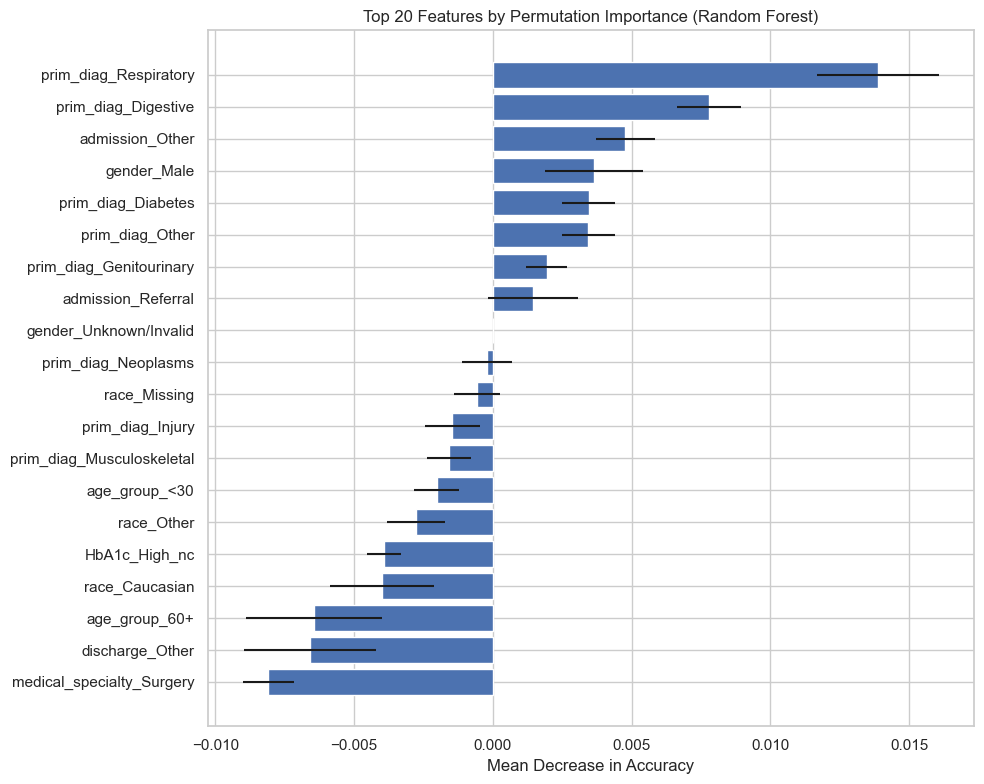

In [48]:
y = df_encoded_cleaned["early_readmission_readmitted"]
X = df_encoded_cleaned.drop(columns=["early_readmission_readmitted"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# === Permutation importance ===
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(perm_df['feature'][:20][::-1], perm_df['importance_mean'][:20][::-1],
         xerr=perm_df['importance_std'][:20][::-1])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Top 20 Features by Permutation Importance (Random Forest)')
plt.tight_layout()
plt.show()

##### This permutation importance plot reveals which variables most influenced the balanced random forest model's ability to predict early hospital readmissions. The top features include several primary diagnosis categories—such as respiratory, digestive, and diabetes—suggesting that the nature of a patient's initial medical condition plays a critical role in their likelihood of returning to the hospital. Gender (especially "Male") also stands out as a relevant factor, along with certain admission sources like transfers from critical access hospitals or other inpatient facilities. These findings align with clinical expectations, where both the severity of a diagnosis and the care pathway can affect readmission risk.

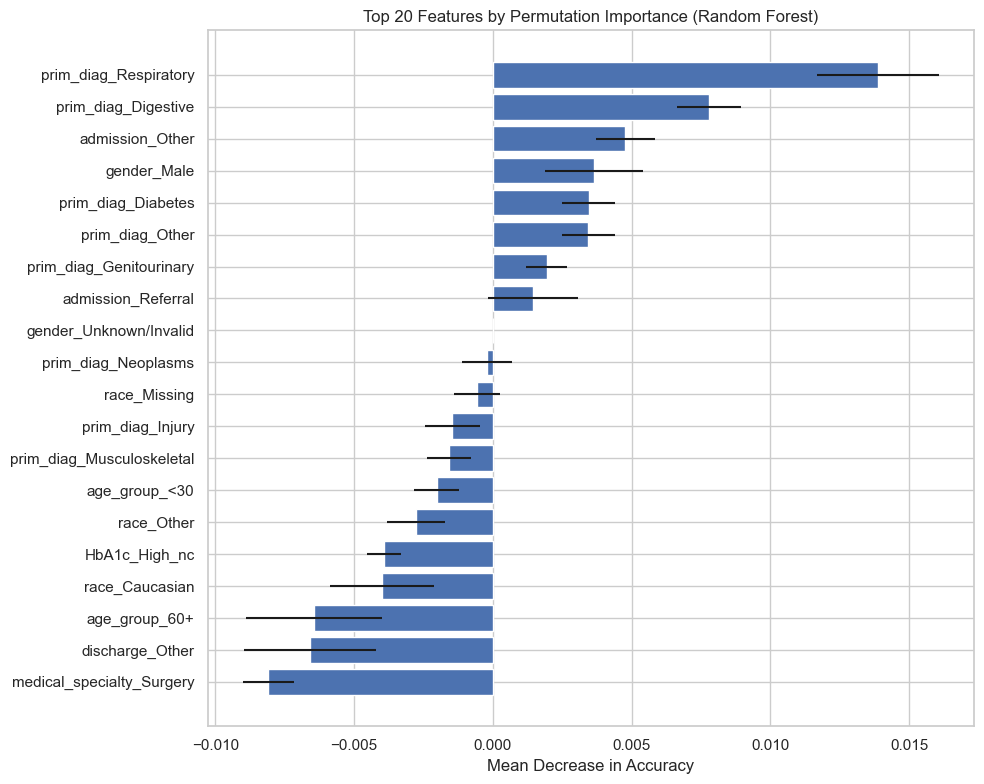

In [49]:
data = data_cleaned.copy()
data = data[
    (data['gender'] != 'Unknown/Invalid') &
    (data['race'] != 'Missing') &
    (data['race'] != '?') &
    (data['medical_specialty'] != '?')
]

cols_to_drop = [
    'encounter_id', 'patient_nbr',
    'admission_type_id', 'discharge_disposition',
    'admission_source_id', 'admission','diag_1','diag_2','diag_3'
]

if 'A1Cresult' in data.columns and 'change' in data.columns:
    a1c_to_change = data.loc[:, 'A1Cresult':'change'].columns.tolist()
    cols_to_drop += a1c_to_change

data = data.drop(columns=cols_to_drop, errors='ignore')
categorical_cols = X.select_dtypes(include=['object', 'category']).columns # choice throughout to use categorical columns and fit numerical as categories (such as gender) - eaier for classification

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(perm_df['feature'][:20][::-1], perm_df['importance_mean'][:20][::-1],
         xerr=perm_df['importance_std'][:20][::-1])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Top 20 Features by Permutation Importance (Random Forest)')
plt.tight_layout()
plt.show()


y_pred = rf.predict(X_test)


##### Again, we find that the most important variables is the primary diagnosis, and gender (though much lower)

In [50]:
# === Fitting with the most important variables ===
data = data_cleaned.copy()
data = data[['readmitted_binary', 'prim_diag', 'gender', 'HbA1c']] # still add HbA1C
X = data.drop(columns=['readmitted_binary',])
y = data['readmitted_binary']
X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first=True avoids dummy trap


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# === == performance metrics ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.41      0.57      3593
           1       0.07      0.62      0.13       277

    accuracy                           0.42      3870
   macro avg       0.50      0.51      0.35      3870
weighted avg       0.87      0.42      0.53      3870



##### These new results show a model that manages to achieve a relatively high recall for the positive class (readmitted = 1), reaching 0.65, meaning it successfully identifies 65% of patients who are actually readmitted early. However, precision for this class is extremely low at 0.07, indicating that most predicted readmissions are false positives. The F1-score for class 1 is only 0.13, confirming that the model struggles to balance precision and recall. For the negative class (not readmitted), precision is high at 0.95, but recall drops to 0.41, suggesting that many non-readmitted cases are misclassified as readmissions. Overall accuracy is low at 42%, and the macro average F1-score is 0.35, reflecting poor generalization across both classes. These results indicate that while the model is better at catching readmissions than before, it does so at the cost of a high false-positive rate and overall poor classification quality.

## II. B. Gradient Boosting methods


In the same spirit as for the Random Forest, we try to implement HistGradientBoosting Classifier and XGBoost Classifier to predict readmission rates from all available covariates. The idea is not so much to identify the effect of the HbA1C test, but to try to predict readmission only. We then implement a permutation importance test to rank features in their contribution to the predictive power of our model, in order to provide some more explainability. Ex ante, we do not expect to see the HbA1C test as ranking as a key feature, as we expect underlying drivers to be able to explain the "Granger causality" of the test on readmission rate.

In [93]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import statsmodels.api as sm

Specific pre-processing to restart from the same point than previously than the Random Forest

### II. B. 1. Data preprocessing

In [94]:
df = df_alt.copy()

In [ ]:
#Variables numériques
num_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_summary = df[num_vars].describe().T
num_summary['missing_pct'] = df[num_vars].isna().mean() * 100
num_summary = num_summary.round(2)

# Variables catégorielles
cat_vars = df.select_dtypes(include='object').columns.tolist()
cat_summary = []

In [96]:
df.replace('?', np.nan, inplace=True)
#we remove the target variable's name from the list of categorical variables to prevent the preprocessor from looking for it and causing bugs
if 'readmitted_binary' in cat_vars:
    cat_vars.remove('readmitted_binary')
if 'readmitted_binary' in num_vars:
    num_vars.remove('readmitted_binary')
if 'readmitted' in cat_vars:
    cat_vars.remove('readmitted')
if 'readmitted' in num_vars:
    num_vars.remove('readmitted')
if 'encounter_id' in num_vars:
    num_vars.remove('encounter_id')
if 'patient_nbr' in num_vars:
    num_vars.remove('patient_nbr')

In [97]:
#Splitting the data before transforming to prevent data leakage, dropping the target variable and all potential related variable to prevent leaks
X = df.drop(["readmitted_binary","readmitted","patient_nbr","encounter_id"],axis =1)
X = pd.DataFrame(X)
y = df["readmitted_binary"]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [98]:
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),cat_vars), #handle unknown categories for categorical data
    (SimpleImputer(strategy='mean'),num_vars), #remplacer par la moyenne
    remainder='passthrough',
    verbose_feature_names_out=False,)

In order to perform randomized_search and cross_validation, we cannot transform the data within a make_pipeline function, hence the application of the preprocessor on the covariates' data beforehand.

In [99]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


### II. B. 2. Histogram Gradient Boosting - Model Fitting

In [100]:
random_state = 42 #seed
model = HistGradientBoostingClassifier(random_state = random_state, max_iter = 1000, early_stopping = True)

##### As the target variable (readmitted_binary) is very imbalanced, we resort to a "f1" scoring metric during the randomized search, which is better than the by default accuracy score to handle imbalanced data.

In [101]:
#RandomizedSearchCV
param_distributions = {"max_depth": randint(3,8),"max_leaf_nodes":randint(15,31),"learning_rate":uniform(0.1,1)}

model_random_search = RandomizedSearchCV(model,param_distributions=param_distributions,scoring= "f1", n_iter=10,n_jobs=2,random_state=random_state,cv=5,verbose=1)

In [102]:
#to handle sparsity
X_train_transformed = X_train_transformed.toarray()

In [103]:
cv = KFold(n_splits=5,shuffle=True, random_state=random_state)
cross_val_results = cross_validate(model_random_search, X_train_transformed, y_train,cv=cv, return_estimator=True)
for estimator in cross_val_results["estimator"]:
    print(estimator.best_params_)
    print("Number of trees:", estimator.best_estimator_.n_iter_)

best_model = max(cross_val_results["estimator"], key=lambda est: est.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}
Number of trees: 12
{'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}
Number of trees: 11
{'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}
Number of trees: 12
{'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}
Number of trees: 10
{'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}
Number of trees: 12


In [104]:
# Extract all estimators and their scores
best_estimators = cross_val_results["estimator"]

# Create a list of (score, params) tuples
results = [(est.best_score_, est.best_params_) for est in best_estimators]

# Find the best combination (highest score)
best_score, best_params = max(results, key=lambda x: x[0])

# Print the results
print("Best Hyperparameter Combination Found:")
print("Best Score:", best_score)
print("Best Hyperparameters:", best_params)

Best Hyperparameter Combination Found:
Best Score: 0.06909955153431471
Best Hyperparameters: {'learning_rate': np.float64(0.8319939418114051), 'max_depth': 7, 'max_leaf_nodes': 19}


### II. B. 3. Histogram Gradient Boosting - Model Validation

In [105]:
X_test_transformed = X_test_transformed.toarray()
y_pred = best_model.predict(X_test_transformed)
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     15878
           1       0.21      0.04      0.07      1618

    accuracy                           0.90     17496
   macro avg       0.56      0.51      0.51     17496
weighted avg       0.85      0.90      0.86     17496



In [106]:
precision = precision_score(y_test, y_pred)
print(precision)

0.2125748502994012


In [107]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8965477823502515


In [108]:
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_transformed)[:, 1])
print(roc_auc)

0.6130693346096495


### II. B. 4. XGBoost - Model Fitting and validation

##### XGBoost code is commented to save running time when one does "run all" - expect 16 min of running time.

In [ ]:
#model2 = XGBClassifier(random_state = random_state, eval_metric = "logloss", use_label_encoder = False, n_estimators = 1000)
#param_distributions2 = {"max_depth": randint(3,8),"learning_rate":uniform(0.01,0.3),"subsample":uniform(0.6,0.4),"colsample_bytree":uniform(0.6,0.4)}
#model_random_search2 = RandomizedSearchCV(model2,param_distributions=param_distributions2, scoring = "f1",n_iter=10,n_jobs=2,random_state=random_state,cv=5,verbose=1)

In [ ]:
#cv = KFold(n_splits=5,shuffle=True, random_state=random_state)
#cross_val_results2 = cross_validate(model_random_search2, X_train_transformed, y_train,cv=cv, return_estimator=True)

In [ ]:
#best_model2 = max(cross_val_results2["estimator"], key=lambda est: est.best_score_)
#y_pred2 = best_model2.predict(X_test_transformed)

In [ ]:
#print(classification_report(y_test,y_pred2))

In [ ]:
#precision2 = precision_score(y_test, y_pred2)
#print(precision2)

In [ ]:
#accuracy2 = accuracy_score(y_test, y_pred2)
#print(accuracy2)

In [ ]:
#roc_auc2 = roc_auc_score(y_test, best_model2.predict_proba(X_test_transformed)[:, 1])
#print(roc_auc2)

### II. B. 5. Block permutation importance for HistGradBoostingClassifier

In [110]:
#by default, for a classifier, it is accuracy which is used as the evaluation criterion
perm_importance = permutation_importance(best_model, X_test_transformed, y_test, n_repeats = 10, random_state = random_state, n_jobs = -1,scoring = "f1")

In [111]:
# Sorting by decreasing importance
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]  # Indices triés du + important au - important

print("Importance des variables (de la plus à la moins influente) :")
for idx in sorted_idx:
    print(f"Feature {idx}: {perm_importance.importances_mean[idx]:.4f} ± {perm_importance.importances_std[idx]:.4f}")

Importance des variables (de la plus à la moins influente) :
Feature 167: 0.0190 ± 0.0019
Feature 161: 0.0156 ± 0.0034
Feature 172: 0.0069 ± 0.0026
Feature 15: 0.0049 ± 0.0009
Feature 163: 0.0047 ± 0.0013
Feature 177: 0.0040 ± 0.0031
Feature 142: 0.0040 ± 0.0015
Feature 111: 0.0040 ± 0.0017
Feature 170: 0.0035 ± 0.0035
Feature 137: 0.0027 ± 0.0009
Feature 131: 0.0026 ± 0.0012
Feature 179: 0.0025 ± 0.0030
Feature 178: 0.0024 ± 0.0052
Feature 113: 0.0023 ± 0.0016
Feature 175: 0.0020 ± 0.0025
Feature 44: 0.0019 ± 0.0011
Feature 12: 0.0016 ± 0.0012
Feature 49: 0.0016 ± 0.0012
Feature 4: 0.0016 ± 0.0010
Feature 140: 0.0015 ± 0.0017
Feature 48: 0.0015 ± 0.0016
Feature 14: 0.0015 ± 0.0019
Feature 174: 0.0014 ± 0.0007
Feature 168: 0.0013 ± 0.0013
Feature 5: 0.0011 ± 0.0005
Feature 34: 0.0009 ± 0.0003
Feature 11: 0.0007 ± 0.0016
Feature 148: 0.0007 ± 0.0014
Feature 16: 0.0005 ± 0.0008
Feature 112: 0.0005 ± 0.0005
Feature 46: 0.0003 ± 0.0006
Feature 169: 0.0002 ± 0.0019
Feature 164: 0.0001 ± 0.0

In [112]:
# Gets names after transformation
feature_names = preprocessor.get_feature_names_out()

#Displays names
for idx in sorted_idx:  # Indices triés par importance
    print(f"{feature_names[idx]}: {perm_importance.importances_mean[idx]:.4f}")

discharge_disposition_id: 0.0190
discharge_Home: 0.0156
num_medications: 0.0069
age_[80-90): 0.0049
admission_Emergency: 0.0047
diag_2: 0.0040
sec_diag_Genitourinary: 0.0040
insulin_Down: 0.0040
num_lab_procedures: 0.0035
prim_diag_Other: 0.0027
prim_diag_Diabetes: 0.0026
number_diagnoses: 0.0025
diag_3: 0.0024
insulin_Steady: 0.0023
number_inpatient: 0.0020
payer_code_nan: 0.0019
age_[50-60): 0.0016
medical_specialty_Other: 0.0016
gender_Female: 0.0016
sec_diag_Diabetes: 0.0015
medical_specialty_Missing: 0.0015
age_[70-80): 0.0015
number_emergency: 0.0014
admission_source_id: 0.0013
gender_Male: 0.0011
payer_code_MC: 0.0009
age_[40-50): 0.0007
third_diag_Circulatory: 0.0007
age_[90-100): 0.0005
insulin_No: 0.0005
medical_specialty_General practice: 0.0003
time_in_hospital: 0.0002
admission_Other: 0.0001
weight_[50-75): 0.0001
medical_specialty_Cardiology: 0.0001
A1Cresult_Norm: 0.0001
third_diag_Musculoskeletal: 0.0000
prim_diag_Musculoskeletal: 0.0000
diabetesMed_Yes: 0.0000
sec_diag

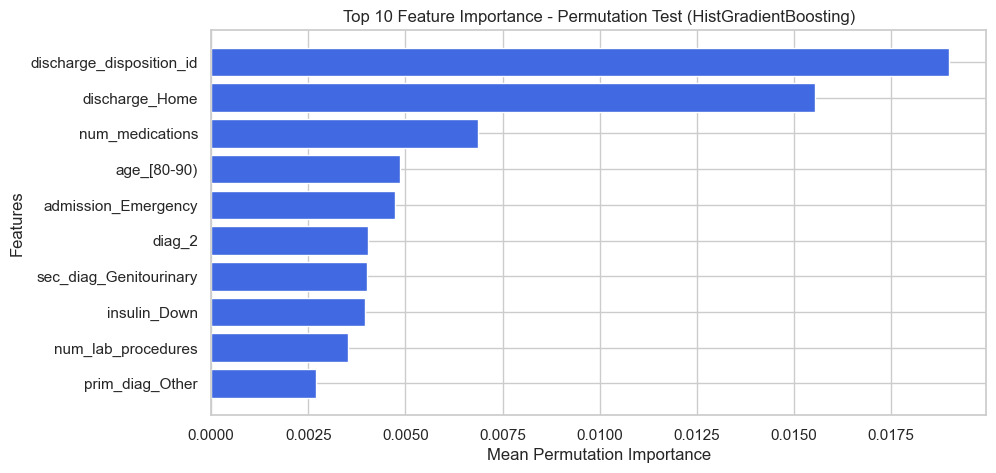

In [113]:
# Sort features by importance (descending order)
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
sorted_features = feature_names[sorted_idx][:10]  # Select top 10
sorted_importances = perm_importance.importances_mean[sorted_idx][:10]

# Plot
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importances, color="royalblue")
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importance - Permutation Test (HistGradientBoosting)")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

##### No feature exceeds a mean permutation importance of more than 2%, perhaps suggesting strong collinearity but reflect mostly the poor predictive performance of the model. No HbA1C results - related variables appear to be well ranked neither. It is therefore not very conclusive overall.

### II. B. 6. Block permutation importance for XGBoost Classifier

In [ ]:
#by default, for a classifier, it is accuracy which is used as the evaluation criterion 
#perm_importance2 = permutation_importance(best_model2, X_test_transformed, y_test, n_repeats = 10, random_state = random_state, n_jobs = -1,scoring = "f1")

In [ ]:
# Tri par importance décroissante et affichage
#sorted_idx2 = np.argsort(perm_importance2.importances_mean)[::-1]  # Indices triés du + important au - important

#print("Importance des variables (de la plus à la moins influente) :")
#for idx in sorted_idx2:
#    print(f"Feature {idx}: {perm_importance2.importances_mean[idx]:.4f} ± {perm_importance2.importances_std[idx]:.4f}")

In [ ]:
# Récupère les noms des colonnes après transformation
#feature_names = preprocessor.get_feature_names_out()

# Affichez les noms avec leur importance
#for idx in sorted_idx2:  # Indices triés par importance
#    print(f"{feature_names[idx]}: {perm_importance2.importances_mean[idx]:.4f}")

In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np

# Sort features by importance (descending order)
#sorted_idx2 = np.argsort(perm_importance2.importances_mean)[::-1]
#sorted_features2 = feature_names[sorted_idx2][:10]  # Select top 10
#sorted_importances2 = perm_importance2.importances_mean[sorted_idx2][:10]

# Plot
#plt.figure(figsize=(10, 5))
#plt.barh(sorted_features2, sorted_importances2, color="royalblue")
#plt.xlabel("Mean Permutation Importance")
#plt.ylabel("Features")
#plt.title("Top 10 Feature Importance - Permutation Test (XGBoost)")
#plt.gca().invert_yaxis()  # Most important feature at the top
#plt.show()

##### Results are similar to HistGradBoost Classifier overall, while being much more computationally intensive.

### In the STATA code you may find a commented replication of the paper (logit) and attempts at getting better results using Post LASSO and Duration Models. Please also refer to the presentation for full extracts of results.


# Conclusion 



### We have not been able to conclude on any "real" causal effect other than in a loosely-defined "Granger" sense. 

### Our predictive models do not perform well due to the issue of imbalanced outcome variable. 

### The paper's treatment of the initial dataset is questionable, the models implemented as well.

### We could benefit from richer datasets and perhaps from conducing a randomized treatment experience.